In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# !pip install -U scikit-plot

import necessary libraries

In [3]:
import math
import scikitplot
import cv2
import seaborn as sns
import matplotlib.pyplot as plt  #the code is importing the pyplot module from the matplotlib library and assigning it an alias plt
from sklearn.model_selection import train_test_split  # imports the train_test_split function from the model_selection module in the scikit-learn library.
from sklearn.preprocessing import LabelEncoder  #The LabelEncoder class is a commonly used class in machine learning for encoding categorical
                                                #features as numeric values.
from sklearn.metrics import classification_report,confusion_matrix#The classification_report function is a commonly used function in machine learning for evaluating
                                                 #the performance of a classification model. It generates a
                                                 #text report that summarizes the precision, recall, F1-score, and support for each class in the classification task.

import tensorflow as tf
from tensorflow.keras import optimizers# It allows you to define a linear stack of layers in the neural network, where the output of one layer
                                              # is fed as input to the next layer in the stack.
from tensorflow.keras.layers import  Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


loading the dataset

In [4]:
file_path = r'D:\BANASHREE\KAGGLE DATASETS\fer2013.csv'

df = pd.read_csv(file_path)

In [5]:
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
#number of emotions
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

Thus we have 7 emotions here, which corresponds to 7 classes

In [7]:
emotion_to_text={0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [8]:
#number of images for each emotion
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

We have an imbalanced dataset

C:\Users\sbana\AppData\Local\Temp\ipykernel_15836\1195110209.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


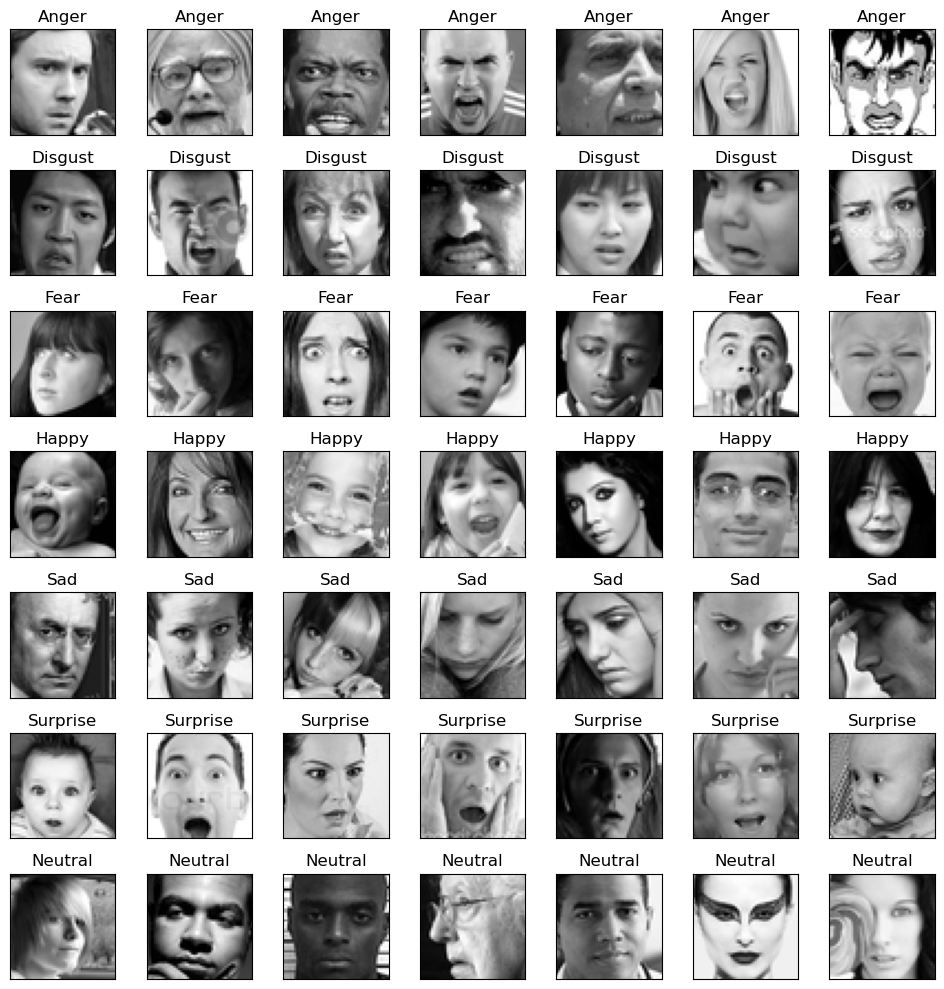

In [9]:
fig=plt.figure(figsize=[10,10])
k=0
for emotion in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==emotion].pixels.iloc[k]
        px=np.array(px.split(' ')).reshape(48,48).astype('float32')
        k+=1
        ax=plt.subplot(7,7,k)
        ax.imshow(px,cmap='gray')
        ax.set_xticks([])  #clearing the x-axis and y-axis ticks
        ax.set_yticks([])
        ax.set_title(emotion_to_text[emotion])
        plt.tight_layout()


In [10]:
df.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [11]:
image_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
image_array = np.stack(image_array, axis=0)
img_array_rgb = []

for i in range(len(image_array)):
    # Convert the image_array values to the [0,255] range
    temp_img = (image_array[i] * 255).astype(np.uint8)
    temp = cv2.cvtColor(temp_img, cv2.COLOR_GRAY2RGB)
    img_array_rgb.append(temp)

img_features = np.array(img_array_rgb)
print(img_features.shape)


(35887, 48, 48, 3)


Each grayscale image in img_array is converted to an RGB image using OpenCV's cvtColor() function with the COLOR_GRAY2RGB flag. It converts a grayscale image to an RGB image by duplicating the grayscale channel three times to get an RGB image. This results in a list of RGB images stored in img_features

In [12]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
label_counts = df.emotion.value_counts()
print(label_counts)

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


we have done one-hot encoding because:


1. Since we are using Softmax activation function at the output layer, the output is an probabaility distribution over the classes. It returns a vector with length equal to the number of classes, where each value in the vector indicates the model's estimated probability for each class. One-hot encoding ensures that the true labels align with the format of the model's predictions.
2.  As we have used categorical cross-entropy as the loss function, it requires the true labels to be in one-hot encoded format. The categorical cross-entropy loss computes the difference between the predicted probabilities (from the softmax) and the true label probabilities (from one-hot encoding).



In [14]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)

# Split train set further into train and validation sets
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, shuffle=True,stratify=Y_train, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape,X_test.shape, Y_test.shape

((24223, 48, 48, 3),
 (8075, 48, 48, 3),
 (24223, 7),
 (8075, 7),
 (3589, 48, 48, 3),
 (3589, 7))

In [15]:
# X_train, X_validation, Y_train, Y_validation = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
# X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

In [16]:
Y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# Decoding one-hot encoded labels
decoded_Y_train = np.argmax(Y_train, axis=1)

# Convert to pandas Series and get value counts
decoded_Y_train_series = pd.Series(decoded_Y_train)
label_counts = decoded_Y_train_series.value_counts()

print(label_counts)


3    6067
6    4183
4    4102
2    3457
0    3343
5    2702
1     369
Name: count, dtype: int64


imbalanced

In [18]:
#normalization
X_train = X_train / 255.
X_validation = X_validation / 255.
X_test = X_test / 255.

#CNN MODEL

In [19]:
base_model = VGG19(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [21]:
num_classes=7
x = base_model.layers[-2].output
# x = GlobalMaxPool2D(name="global_pool")(x)
# x= Dense(128, activation="relu")(x) 

# out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

# Applying MaxPooling2D
x = GlobalMaxPool2D(name="global_pool")(x)
# Adding the first Dense layer
x = Dense(128, activation="relu", name="dense_1")(x)

# Applying Batch Normalization
x = BatchNormalization(name="batchnorm_7")(x)

# Applying the second Dropout
# x = Dropout(0.5, name="dropout_4")(x)

# Final Dense layer for classification
out = Dense(7, activation="softmax", name="out_layer")(x)

In [22]:
model = Model(inputs=base_model.input, outputs=out)


In [23]:
#Freeze the initial layers
for layer in model.layers[:3]:
    layer.trainable = False


In [24]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [25]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)
# Early stopping based on validation loss
early_stopping_loss = EarlyStopping(
    monitor='val_loss',

    patience=5,
    verbose=1,
    restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler
]

In [26]:
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.20,
#     height_shift_range=0.20,
#     shear_range=0.20,
#     zoom_range=0.20,
#     horizontal_flip=True,
# )
# train_datagen.fit(train_images)

In [27]:
# # Augmentating images with emotion 1 since there is lower number of images for it.
augment_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.30,
    height_shift_range=0.30,
    shear_range=0.30,
    zoom_range=0.30,
    horizontal_flip=True,
)

# # Extract images of emotion 1
emotion_1_indices = np.where(np.argmax(Y_train, axis=1) == 1)[0]
emotion_1_images = X_train[emotion_1_indices]
emotion_1_labels = Y_train[emotion_1_indices]

# # Generate augmented images for emotion 1
augmented_images = []
augmented_labels = []
augmentation_multiplier = 11  # Decide how many augmented images you want per original image

for i in range(augmentation_multiplier):
    for x_batch, y_batch in augment_datagen.flow(emotion_1_images, emotion_1_labels, batch_size=len(emotion_1_images), shuffle=False):
        augmented_images.extend(x_batch)
        augmented_labels.extend(y_batch)
        break  # to stop the infinite loop


# # Combine original training data with augmented data
X_train_combined = np.concatenate([X_train, np.array(augmented_images)])
Y_train_combined = np.concatenate([Y_train, np.array(augmented_labels)])


In [28]:
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.20,
#     height_shift_range=0.20,
#     shear_range=0.20,
#     zoom_range=0.20,
#     horizontal_flip=True,
# )
# train_datagen.fit(X_train_combined)

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.20,
    zoom_range=0.20,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
   rotation_range=20, 
   width_shift_range = 0.1,
   height_shift_range = 0.1,
   shear_range=0.20, 
   zoom_range = 0.2,
   horizontal_flip = True,
 )
train_datagen.fit(X_train)
val_datagen.fit(X_validation)

In [30]:
batch_size=32
train_generator = train_datagen.flow(X_train_combined,Y_train_combined, batch_size=batch_size)
val_generator = val_datagen.flow(X_validation, Y_validation, batch_size=batch_size)

In [31]:
batch_size=32
epochs=30
opt = optimizers.Adam(0.0001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,metrics = ['accuracy'])


The model is overfitting if less number of layers of vgg19 are freezed
thye nodel perform worse when high numbers of larers are freezed

In [32]:
history = model.fit(
    train_datagen.flow(X_train_combined,Y_train_combined, batch_size=batch_size),
    validation_data=(X_validation, Y_validation),
    steps_per_epoch=len(X_train_combined) / batch_size,
    epochs=epochs,

    callbacks=callbacks,
    use_multiprocessing=False
)

Epoch 1/30
883/883 [==============================] - 19s 13ms/step - loss: 1.4476 - accuracy: 0.4586 - val_loss: 1.3870 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 2/30
883/883 [==============================] - 11s 13ms/step - loss: 1.2026 - accuracy: 0.5495 - val_loss: 1.3634 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 3/30
883/883 [==============================] - 11s 12ms/step - loss: 1.1165 - accuracy: 0.5871 - val_loss: 1.3065 - val_accuracy: 0.5357 - lr: 1.0000e-04
Epoch 4/30
883/883 [==============================] - 11s 12ms/step - loss: 1.0485 - accuracy: 0.6069 - val_loss: 1.3388 - val_accuracy: 0.5235 - lr: 1.0000e-04
Epoch 5/30
883/883 [==============================] - 11s 13ms/step - loss: 1.0057 - accuracy: 0.6269 - val_loss: 1.1255 - val_accuracy: 0.5799 - lr: 1.0000e-04
Epoch 6/30
883/883 [==============================] - 11s 12ms/step - loss: 0.9690 - accuracy: 0.6419 - val_loss: 1.4527 - val_accuracy: 0.4617 - lr: 1.0000e-04
Epoch 7/30
883/883 [==============

C:\Users\sbana\AppData\Local\Temp\ipykernel_15836\2433867150.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


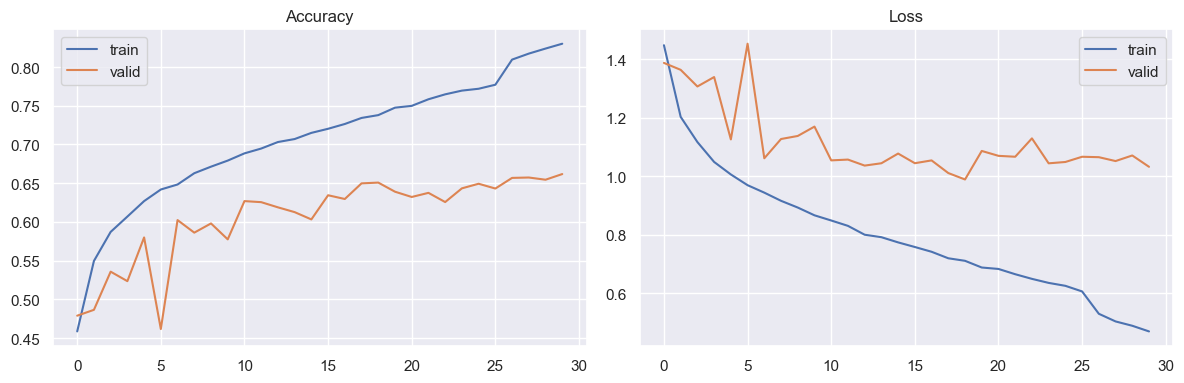

In [33]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
# sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(data=history.history['accuracy'], label='train')
sns.lineplot(data=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history.history['loss'], label='train')
sns.lineplot(data=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()


In [34]:
# # Save the entire model (architecture + weights + optimizer state)
model.save('face_recognition_model_with_TF.h5')

# If you want to save only the weights
# model.save_weights('face_weights.h5')

In [35]:
loss = model.evaluate(X_test, Y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 5ms/step - loss: 1.0184 - accuracy: 0.6757
Test Acc: 0.6756756901741028


In [36]:
error

NameError: name 'error' is not defined

In [ ]:
from google.colab import files
# If you saved only the weightsa
# files.download('face_weights.h5')

In [ ]:
files.download('face_recognition_model_with_TF.h5')

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('face_recognition_model_with_TF.h5')

In [ ]:
# Get model predictions
val_preds = model.predict(X_validation)
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(Y_validation, axis=1)

# Plot confusion matrix
cm = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification report
print(classification_report(val_true_classes, val_preds_classes))


In [ ]:
loss = model.evaluate(X_test, Y_test)
print("Test Acc: " + str(loss[1]))